## Using different MC packages for Bayesian sampling

refnx can work with a variety of MC packages for inference. This notebook will demonstrate the use of various packages:

- [emcee](https://emcee.readthedocs.io/en/stable/) (vendored into refnx), 
- [pymc](https://www.pymc.io/welcome.html)
- [dynesty](https://dynesty.readthedocs.io/en/stable/)

An excellent reference to see how to use a wide range of packages for statistical inference is https://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere.

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy

import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import (
    Transform,
    CurveFitter,
    Objective,
    Model,
    Parameter,
    pymc_model,
    process_chain,
)
from refnx.reflect import SLD, Slab, ReflectModel

import pymc as pm
import dynesty
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


It's important to note down the versions of the software that you're using, in order for the analysis to be reproducible.

In [2]:
print(
    f"refnx: {refnx.version.version}\n"
    f"scipy: {scipy.version.version}\n"
    f"numpy: {np.version.version}"
)

refnx: 0.1.45.dev0+f70fbb9
scipy: 1.14.0.dev0+852.cca3e4c
numpy: 1.26.4


The dataset we're going to use as an example is distributed with every install. The following cell determines its location.

In [3]:
pth = os.path.dirname(refnx.__file__)
DATASET_NAME = "c_PLP0011859_q.txt"
file_path = os.path.join(pth, "analysis", "test", DATASET_NAME)
data = ReflectDataset(file_path)

### The Structure

In [4]:
si = SLD(2.07, name="Si")
sio2 = SLD(3.47, name="SiO2")
film = SLD(2.0, name="film")
d2o = SLD(6.36, name="d2o")

In [5]:
# first number is thickness, second number is roughness
# a native oxide layer
sio2_layer = sio2(30, 3)

# the film of interest
film_layer = film(250, 3)

# layer for the solvent
d2o_layer = d2o(0, 3)

In [6]:
sio2_layer.thick.setp(bounds=(15, 50), vary=True)
sio2_layer.rough.setp(bounds=(1, 15), vary=True)

film_layer.thick.setp(bounds=(200, 300), vary=True)
film_layer.sld.real.setp(bounds=(0.1, 3), vary=True)
film_layer.rough.setp(bounds=(1, 15), vary=True)

d2o_layer.rough.setp(vary=True, bounds=(1, 15))

In [7]:
structure = si | sio2_layer | film_layer | d2o_layer

In [8]:
print(sio2_layer.parameters)

________________________________________________________________________________
Parameters:     'SiO2'     
<Parameter:'SiO2 - thick' , value=30          , bounds=[15.0, 50.0]>
________________________________________________________________________________
Parameters:     'SiO2'     
<Parameter: 'SiO2 - sld'  , value=3.47  (fixed) , bounds=[-inf, inf]>
<Parameter: 'SiO2 - isld' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'SiO2 - rough' , value=3          , bounds=[1.0, 15.0]>
<Parameter:'SiO2 - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>


### ReflectModel, Objective, Curvefitter

In [9]:
model = ReflectModel(structure, bkg=3e-6, dq=5.0)
model.scale.setp(bounds=(0.6, 1.2), vary=True)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)

In [10]:
objective = Objective(model, data, transform=Transform("logY"))

In [11]:
fitter = CurveFitter(objective)
fitter.fit("differential_evolution", target="nlpost");

-564.7877616660005: : 41it [00:01, 21.64it/s] 


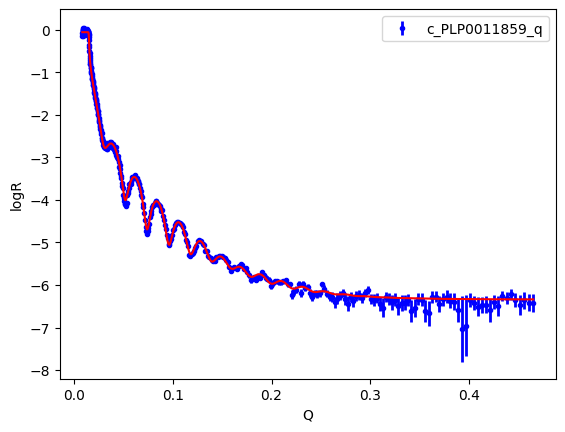

In [12]:
objective.plot()
plt.legend()
plt.xlabel("Q")
plt.ylabel("logR")
plt.legend();

### emcee

Now lets do a MCMC sampling of the curvefitting system. First we do sampling to burn-in the system. We'll also checkout the autocorrelation time of the system. We'll then discard the burn-in samples because the initial chain might not be representative of an equilibrated system (i.e. distributed around the mean with the correct covariance).

In [13]:
fitter.sample(3000, pool=8);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:22<00:00, 21.03it/s]


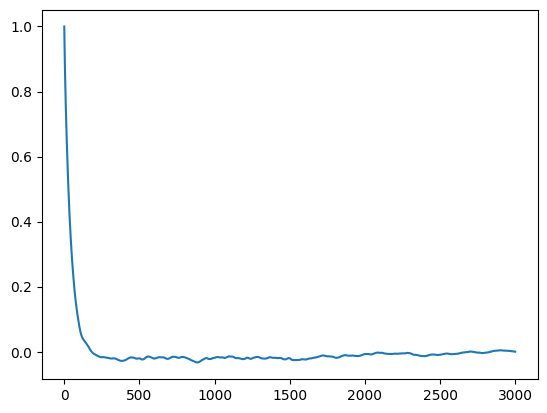

In [14]:
plt.plot(fitter.acf()[:, 4])
fitter.reset()

We then follow up with a production run, only saving 1 in 200 samples. This is to remove autocorrelation. We save 15 steps, giving a total of 15 * 200 samples (200 walkers is the default).

In [15]:
res = fitter.sample(15, nthin=200, pool=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:28<00:00, 14.39it/s]


This seems to be an effective sampling rate of ~15 * 200 / 210 = 15 samples/sec
In the final output of the sampling each varying parameter is given a set of statistics. `Parameter.value` is the median of the chain samples. `Parameter.stderr` is half the [15, 85] percentile, representing a standard deviation.

In [16]:
print(objective)

________________________________________________________________________________
Objective - 5726666000
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 919.592076856273
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.87943 +/- 0.00318, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.60051e-07 +/- 2.21e-08, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Si'      
<Parameter: 'Si - thick'  , value=0  (fixed) , 

A corner plot shows the covariance between parameters. You need to install the *matplotlib* and *corner* packages to create these graphs.

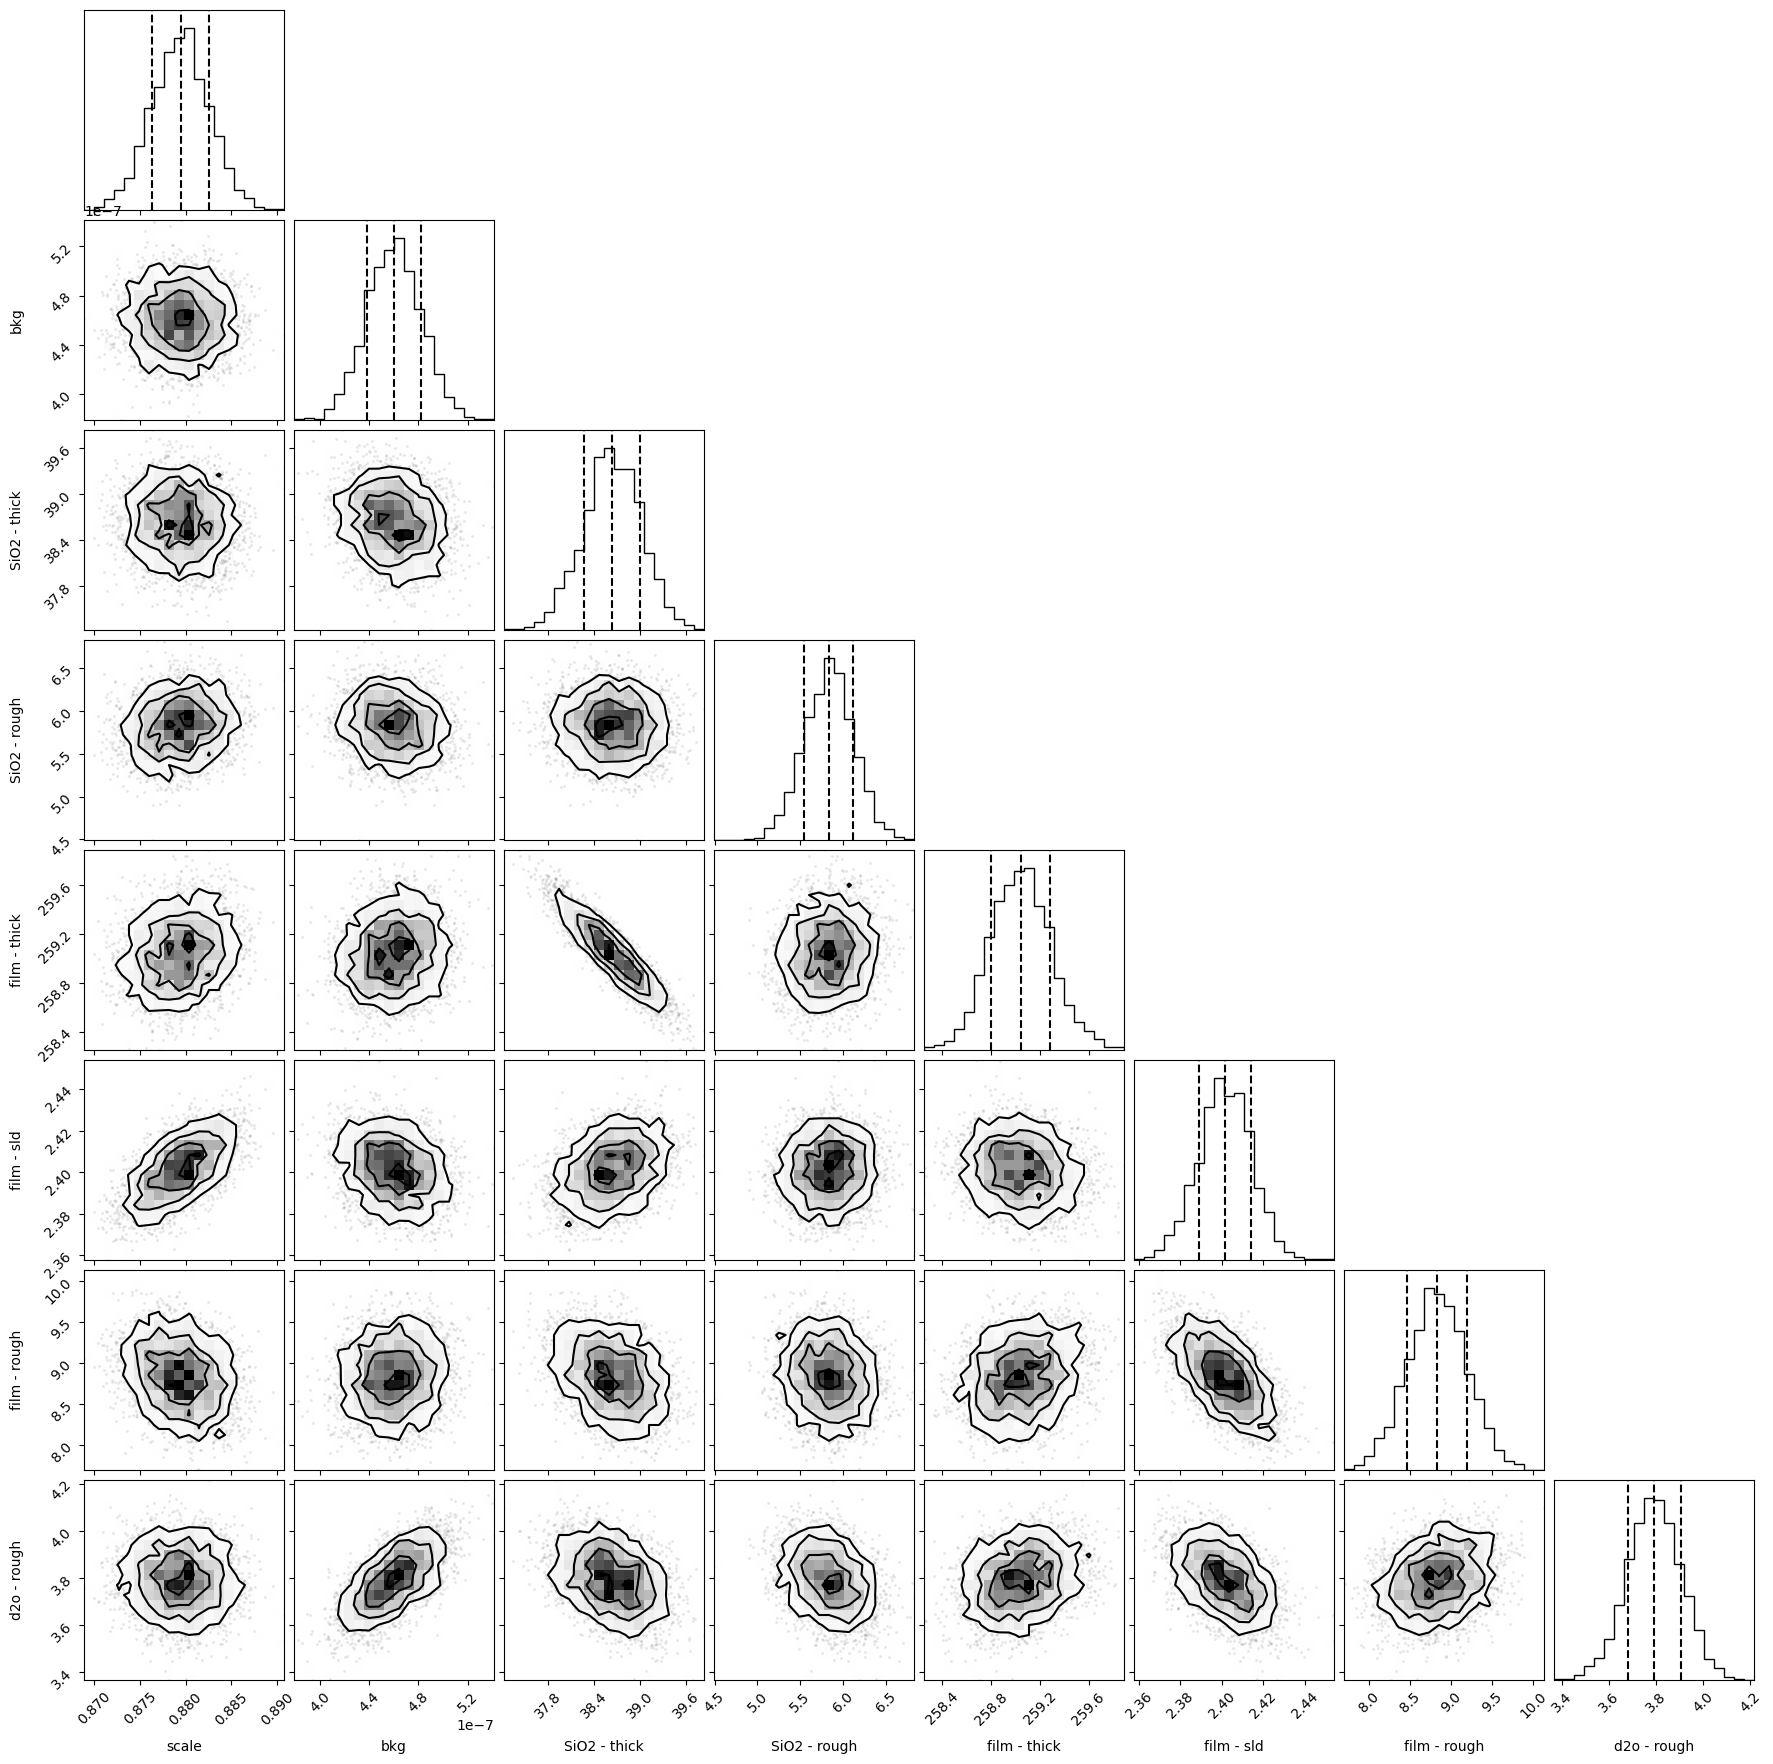

In [17]:
objective.corner();

Once we've done the sampling we can look at the variation in the model at describing the data. In this example there isn't much spread.

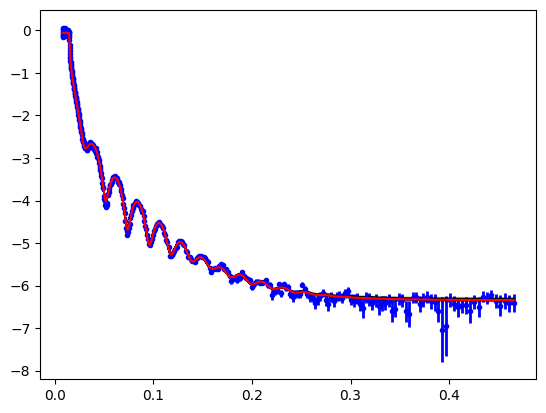

In [18]:
objective.plot(samples=300);

In a similar manner we can look at the spread in SLD profiles consistent with the data.

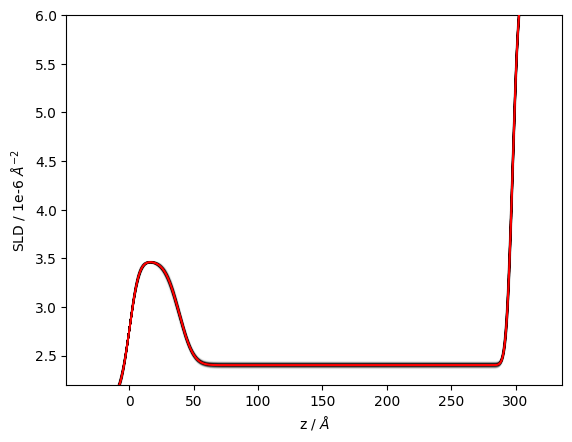

In [19]:
structure.plot(samples=300)
plt.ylim(2.2, 6);

### Sampling with pymc

`pymc` is also an excellent Bayesian package. `refnx` has some features built in to work with `pymc` models. You'll need to install `pymc` and `arviz` to run this section.

In [20]:
from refnx.analysis import pymc_model
import pymc as pm
import arviz as az

To do the sampling we're going to use the `DEMetropolis` stepper. `refnx` can use NUTS, but it seems to work very slowly with reflectometry datasets (via a [black-box model](https://www.pymc.io/projects/examples/en/latest/howto/blackbox_external_likelihood_numpy.html)). More investigations need to be done on the refnx codebase to try and improve NUTS performance.

In [21]:
with pymc_model(objective) as _model:
    starter = {
        f"p{n}": par.value for n, par in enumerate(objective.varying_parameters())
    }
    trace = pm.sample(draws=10000, chains=10, initvals=starter, step=pm.DEMetropolis())

Population sampling (10 chains)
DEMetropolis: [p0, p1, p2, p3, p4, p5, p6, p7]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Output()

Population parallelization failed. Falling back to sequential stepping of chains.


Output()

Sampling 10 chains for 1_000 tune and 10_000 draw iterations (10_000 + 100_000 draws total) took 82 seconds.


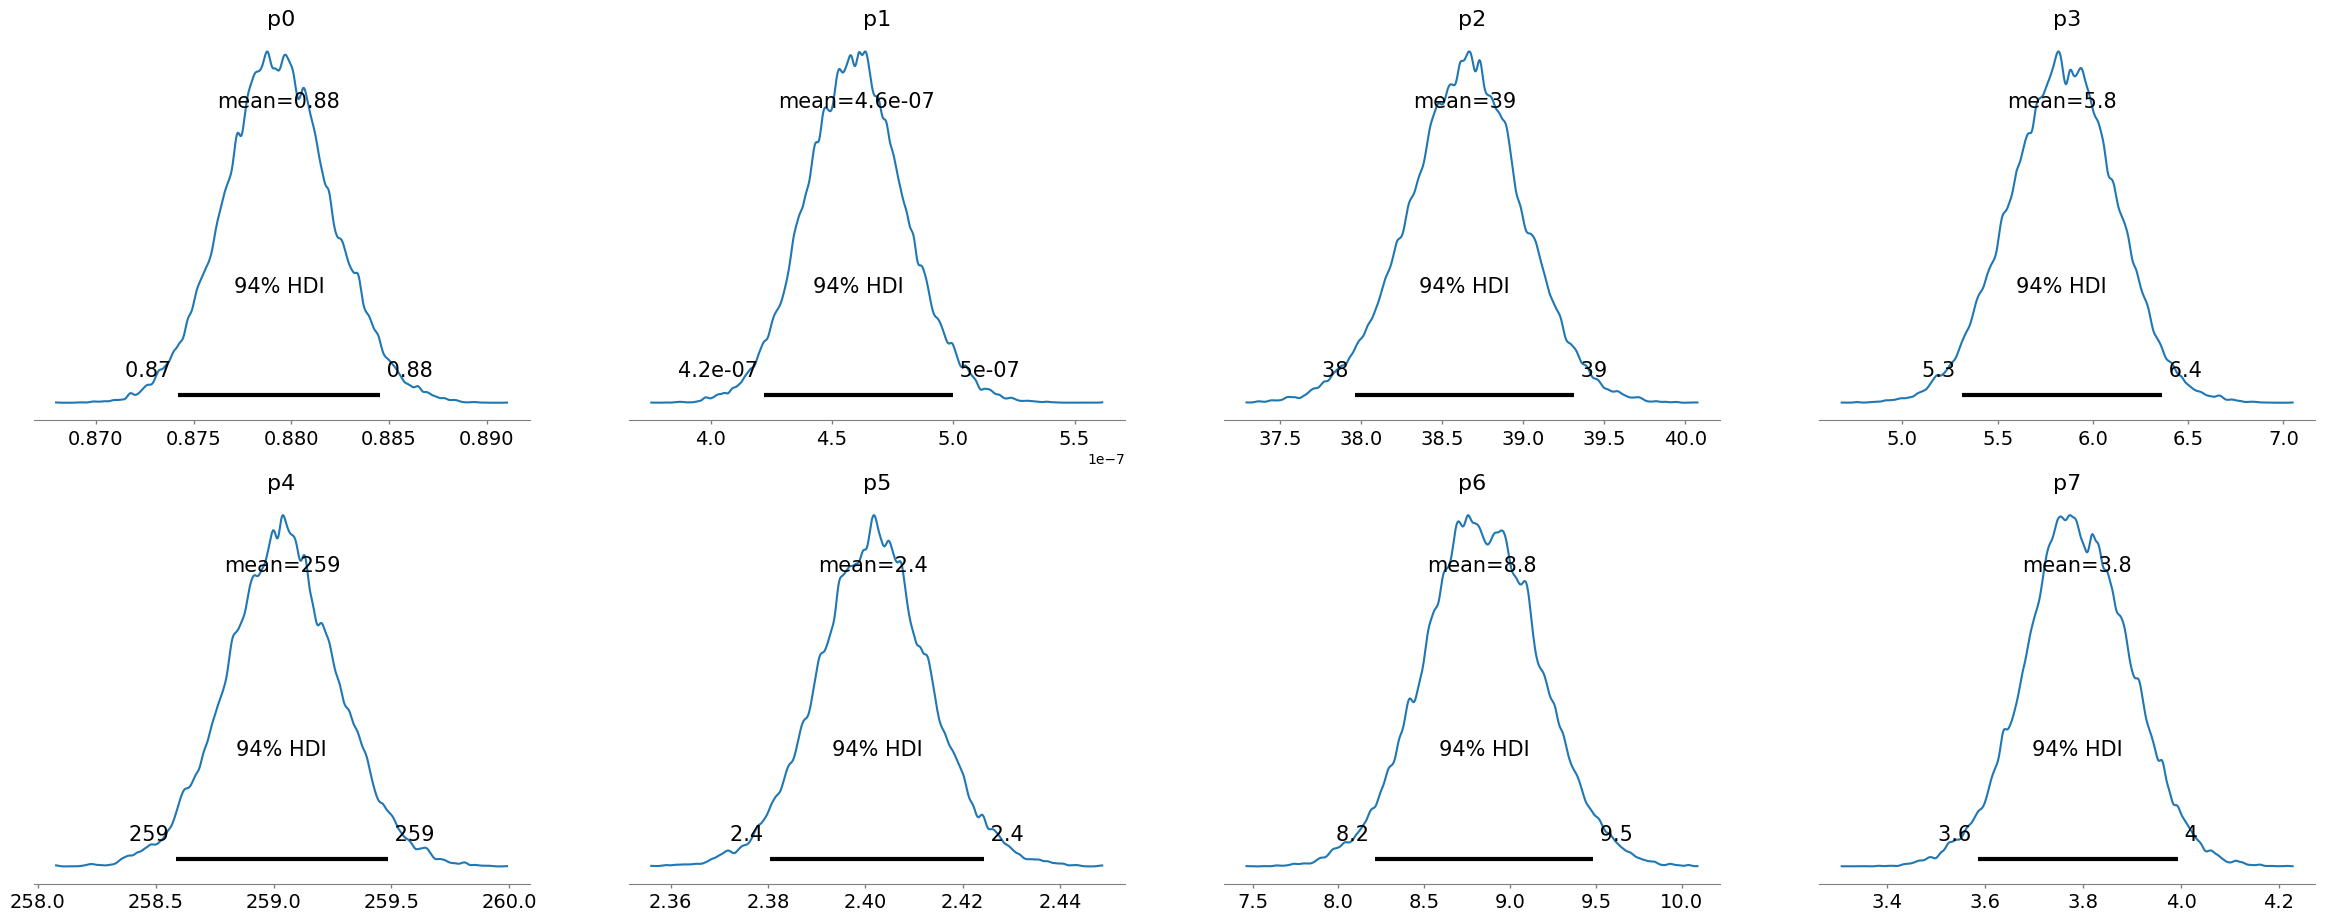

In [22]:
az.plot_posterior(trace);

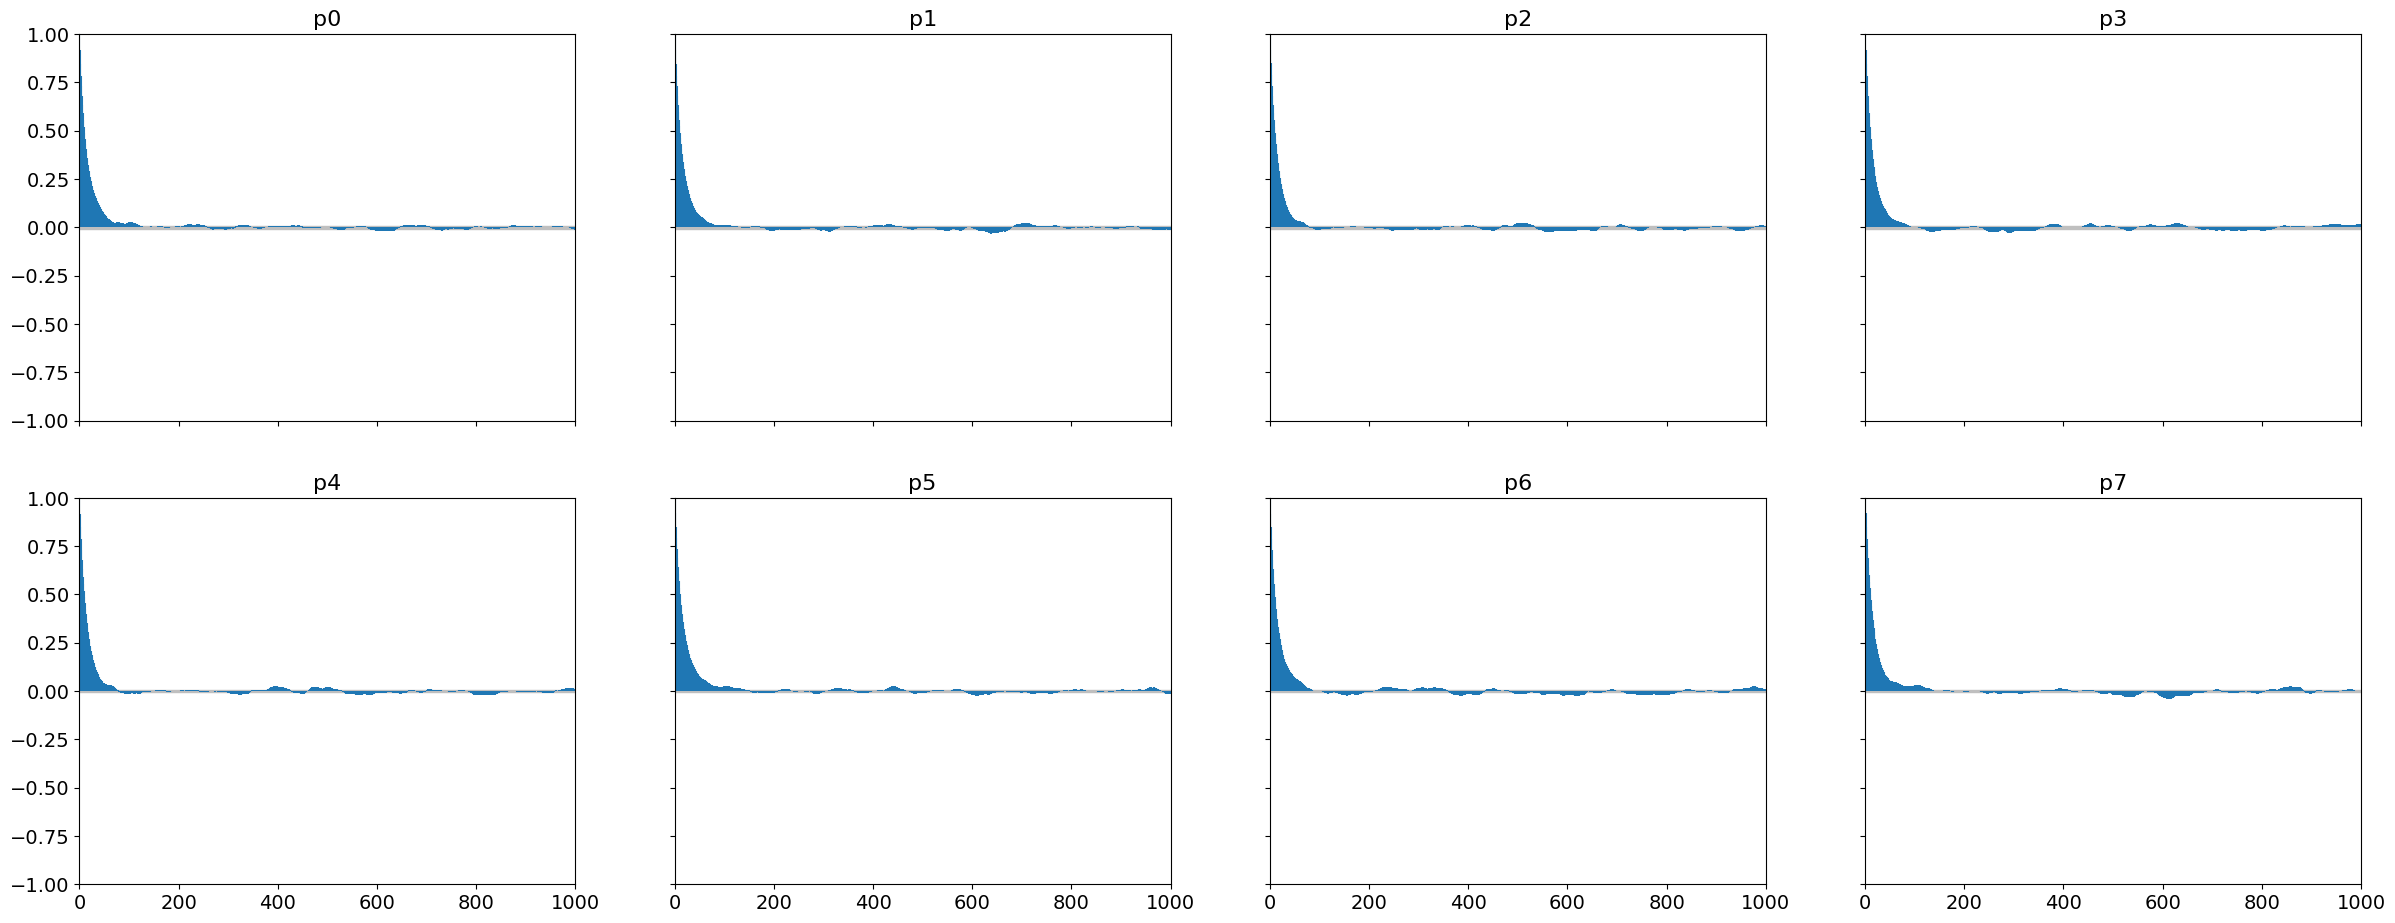

In [23]:
az.plot_autocorr(trace, combined=True, max_lag=1000);

Given that the autocorrelation time is ~100, this corresponds to something like 10 * 10000 / 100 = 1000 independent samples.
The time taken on my machine was ~80 sec, corresponding to an effective sampling rate of ~13 samples/sec. Note that the emcee was sampling at an effective rate of ~15 samples/sec. *The two rates are effectively the same*. There is room to tweak both sampling runs to slightly speed them up.

Note how all the parameters are labelled `p0, p1, ..., pn`. Each of those parameters correspond to a Parameter in `Objective.varying_parameters()`. Compared to the inbuilt processing one would have to do some manual processing. Let's work out some stats for `p4`, which corresponds to a layer thickness.

In [24]:
print(objective.varying_parameters()[4])

<Parameter:'film - thick' , value=259.01 +/- 0.244, bounds=[200.0, 300.0]>


In [25]:
# grab hold of the MCMC chain for that parameter
chain = trace.posterior["p4"].data
print(chain.shape)


# work out some of the quantile statistics.
def process_chain_for_parameter(chain):
    quantiles = np.quantile(chain, [0.158, 0.5, 0.842])
    return quantiles[1], 0.5 * (quantiles[-1] - quantiles[0])


process_chain_for_parameter(chain)

(10, 10000)


(259.03719841291434, 0.23547709737013633)

In [26]:
# Let's create a function to update the best fit.
def update_objective_from_trace(objective, trace):
    vpars = objective.varying_parameters()
    for i, vpar in enumerate(vpars):
        median, sd = process_chain_for_parameter(trace.posterior[f"p{i}"])
        vpar.value = median
        vpar.stderr = sd


update_objective_from_trace(objective, trace)

In [27]:
print(objective)

________________________________________________________________________________
Objective - 5726666000
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 919.5972115486852
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.879284 +/- 0.00274, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.59659e-07 +/- 2.04e-08, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Si'      
<Parameter: 'Si - thick'  , value=0  (fixed) 

The parameter values from `pymc` and `emcee` are effectively the same.

### Sampling with dynesty

In [28]:
import dynesty

You can find out how to estimate posteriors with dynesty using this page, https://dynesty.readthedocs.io/en/stable/dynamic.html. It's best to use the dynamic nested sampler, then you need to reweight the samples with the weights. Dynesty provides a utility function for that.
You can also use dynesty to perform model comparison by looking at the evidence term.

In [29]:
nested_sampler = dynesty.DynamicNestedSampler(
    objective.logl, objective.prior_transform, ndim=len(objective.varying_parameters())
)
nested_sampler.run_nested()
# process the samples
chain = nested_sampler.results.samples_equal()

# another way of processing the samples (reweighting is needed)
logZdynesty = nested_sampler.results.logz[-1]  # value of logZ
weights = np.exp(nested_sampler.results.logwt - logZdynesty)
chain = dynesty.utils.resample_equal(nested_sampler.results.samples, weights)

print(chain.shape)

28576it [00:49, 578.67it/s, batch: 5 | bound: 11 | nc: 1 | ncall: 124334 | eff(%): 22.939 | loglstar: 563.200 < 570.525 < 568.975 | logz: 536.428 +/-  0.179 | stop:  0.755]              


(28576, 8)


The size of the chain resulting from the `samples_equal` method is not equal to the number of effective samples. One can estimate the effective number of posterior samples resulting from a run using the following:

In [30]:
def ess(weights):
    """
    Estimate the effective sample size from the weights.

    Args:
        weights (array_like): an array of weights values for each nested sample

    Returns:
        int: the effective sample size
    """

    N = len(weights)
    w = weights / weights.sum()
    ess = N / (1.0 + ((N * w - 1) ** 2).sum() / N)

    return int(ess)


print("effective number of samples: ", ess(np.exp(weights)))

effective number of samples:  28575


The effective sampling rate for dynesty seems to be ~28000/50 ~ 570 samples/sec.

Let's process the chain to put the statistics into the objective. Here we'll use the `process_chain` utility function that's designed for use with emcee chains. This function assumes that the chain has shape `(nsteps, nwalkers, nvars)`. The chain from dynesty has shape `(nsamples, nvars)`, so we can fake the dynesty chain into looking like an emcee chain by putting an extra axis in.

In [31]:
process_chain(objective, chain[:, None, :]);

In [32]:
print(objective)

________________________________________________________________________________
Objective - 5726666000
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 919.5911226577888
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.879434 +/- 0.00305, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.59031e-07 +/- 2.24e-08, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Si'      
<Parameter: 'Si - thick'  , value=0  (fixed) 

## Conclusions

Hopefully you've found it useful to see how the three sampling packages can be used to obtain posterior distributions for the parameter set. All have high performance. The `emcee` sampler will probably stay the default, but it may be useful to look into both `pymc` and `dynesty` to see what useful (unique) features they may offer - especially if `dynesty` appears to have a much faster sampling rate.